In [2]:
from google.colab import drive
drive.mount('/content/drive')

#dir_pfx = '/content/drive/'
#data_dir = '../data/Vehicules1024/'

dir_pfx = '/content/drive/Team Drives/ECE285_Project/code/prototype/DenseSRGAN/'
data_dir = dir_pfx + '../data/Vehicules1024/'

# Add the local_modules directory to the set of paths
# Python uses to look for imports.
import sys
sys.path.append(dir_pfx)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!pip3 install -q git+https://www.github.com/keras-team/keras-contrib.git
import os
import numpy as np
from matplotlib import pyplot as plt
import utils


## REDUNDANT MAYBE
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.training_utils import multi_gpu_model

import datetime
import matplotlib.pyplot as plt
import sys
# from google.col
import numpy as np
import os

import keras.backend as K
import glob


import numpy as np
import imageio
from keras.utils import Sequence
from os import listdir
from os.path import isfile, join
from skimage.transform import downscale_local_mean
import random
import tensorflow as tf
import scipy

In [0]:
def normalize(image):
  return image/255.0    

def read_VEDAI(subset, PATH_TO_VEHICLES_FOLDER):
    # Takes in the full path to the unzipped "VEHICULES" folder
    # Returns mapping dict, RGB and Infrared images in 
    # (images, x, y, channels) format,
    # saves a txt file with mapping of rgb/infra idx to filename
    # NUM_FILES = 2536
    # MAX_INDEX = 1272
    X_PIXELS = 1024
    Y_PIXELS = 1024
    PATH_TO_VEHICLES_FOLDER = PATH_TO_VEHICLES_FOLDER#[0]

    onlyfiles = [f for f in listdir(PATH_TO_VEHICLES_FOLDER) if isfile(
        join(PATH_TO_VEHICLES_FOLDER, f)) and "png" in f]
    # assert len(onlyfiles) == NUM_FILES, "Not the full VEDAI 1024 Dataset"
    rgb = np.zeros((len(subset), X_PIXELS, Y_PIXELS, 3))
    infra = np.zeros((len(subset), X_PIXELS, Y_PIXELS, 1))
    indices = subset

    print(indices)
    print(rgb.shape)
    index_filename_map = {}
    im_cnt = 0

    for index in indices:
        pair = [file for file in onlyfiles if str(index) in file]
        if pair:
            for file in pair:
                index_filename_map[im_cnt] = file.split('_')[0]
                im = imageio.imread(PATH_TO_VEHICLES_FOLDER + '/' + file)
                if "co" in file:
                    # print('Inserting RGB @ '+ str(im_cnt))
                    rgb[im_cnt, :, :, :] = np.reshape(
                        im, (tuple([1]) + im.shape))
                elif "ir" in file:
                    # print('Inserting Infra @ '+ str(im_cnt))
                    infra[im_cnt, :, :, :] = np.reshape(
                        im, (tuple([1]) + im.shape + tuple([1])))
            im_cnt = im_cnt + 1
        else:
            print("The following image is missing!: " + index)
    # print(index_filename_map)
    f = open(PATH_TO_VEHICLES_FOLDER + "_mapping.txt", "w")
    f.write(str(index_filename_map))
    f.close()
    return rgb, infra


def scan_dataset(PATH_TO_VEHICLES_FOLDER, number_of_imgs):
    # Takes in the full path to the unzipped "VEHICULES" folder
    # Returns a list of all the files
    # and saves a dataset summary text file with list of all file names
    MAX_INDEX = number_of_imgs
    PATH_TO_VEHICLES_FOLDER = PATH_TO_VEHICLES_FOLDER
    indices = [format(n, '08') for n in range(MAX_INDEX)]
    export_files = []

    onlyfiles = [f for f in listdir(PATH_TO_VEHICLES_FOLDER) if isfile(
        join(PATH_TO_VEHICLES_FOLDER, f)) and "png" in f]

    for index in indices:
        pair = [file for file in onlyfiles if str(index) in file]
        if pair:
            for file in pair:
                if "co" in file:
                    export_files.append(file.split('_')[0])
        else:
            print("The following image is missing!: " + index)
    np.savetxt(PATH_TO_VEHICLES_FOLDER + '_summary.txt',
               export_files, delimiter=" ", fmt="%s")

    return export_files


def create_subsets(imgs, output_path, use_validation=True,
                   training_percent=0.7, testing_percent=0.3, SEED=1):
    # Takes a list of image file names and shuffles
    # them before splitting them into required subsets
    # Saves txt files containing the names of the files
    # used in each subset, no return value

    assert training_percent + \
        testing_percent == 1, "Training + testing percents must equal 1."
    random.seed(SEED)
    random.shuffle(imgs)
    print('Using ' + str(len(imgs)) + ' images.')
    print('Saving files to ' + output_path)
    if not use_validation:
        training_imgs = imgs[:int(len(imgs) * training_percent)]
        testing_imgs = imgs[int(len(imgs) * training_percent):]
        np.savetxt(output_path + 'training.txt',
                   training_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'testing.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        return training_imgs, testing_imgs
    else:
        validation_split = 0.3  # use 30% of training dataset for validation
        training_imgs = imgs[int(len(imgs) * validation_split *
                                 training_percent):int(len(imgs) *
                                                       training_percent)]
        validation_imgs = imgs[:int(
            len(imgs) * validation_split * training_percent)]
        testing_imgs = imgs[int(len(imgs) * training_percent):]
        np.savetxt(output_path + 'validation.txt',
                   validation_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'training.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'testing.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        return training_imgs, validation_imgs, testing_imgs


def save_VEDAI(rgb, infra):
    # Takes in arrays of rgb and infrared images
    # Saves them to disk, no return value
    np.save("vedai_rgb_all.npy", rgb)
    np.save("vedai_infra_all.npy", infra)


def load_VEDAI():
    # No parameters, expected to run in directory with VEDAI.npy files
    # Returns two arrays with rgb and infrared images respectively
    rgb = np.load("vedai_rgb_all.npy")
    infra = np.load("vedai_infra_all.npy")
    return rgb, infra


def data_explore(data):
    print("Shape of the data is" + str(data.shape))
    print("Dtype of the data is" + str(data.dtype))


def combine_rgb_infra(rgb, infra):
    # Concatenates the two modalities along the channels axis
    four_channel = np.concatenate((rgb, infra), axis=-1)
    return four_channel

  
def overlapping_patches(images, patch_size=(64, 64), padding="VALID"):
    sess = tf.Session()

    num_images, size_x, size_y, channels = images.shape
    ims = tf.convert_to_tensor(images)
    patch_x, patch_y = patch_size
    patches = tf.extract_image_patches(ims, [1, patch_x, patch_y, 1], [
        1, patch_x, patch_y, 1], [1, 1, 1, 1], padding=padding)
    patches_shape = tf.shape(patches)
    with sess.as_default():
        np = tf.reshape(patches, [tf.reduce_prod(patches_shape[0:3]),
                                  patch_x, patch_y, channels]).eval()
        return np  


def non_overlapping_patches(image, patch_size=(64, 64)):
    size_x, size_y, channels = image.shape
    patch_x, patch_y = patch_size
    im_pad = np.pad(image, ((0, patch_x - size_x % patch_x),
                            (0, patch_y - size_y % patch_y), (0, 0)),
                    mode="constant")
    if size_x % patch_x == 0 and size_y % patch_y == 0:
        im_pad = image
    pad_x, pad_y, channels = im_pad.shape
    print(im_pad.shape)
    num_patches = (pad_x // patch_x) * (pad_y // patch_y)
    patches = np.zeros((num_patches, patch_x, patch_y, channels))
    counter = 0
    for i in range((pad_x // patch_x)):
        for j in range((pad_y // patch_y)):
            x_s = i * patch_x
            y_s = j * patch_y
            patches[counter, :, :, :] = im_pad[x_s:x_s + patch_x,
                                               y_s:y_s + patch_y, :]
            counter += 1
    return patches


def downsample_image(image, block=(4, 4, 1)):
    # Downsamples numpy array image by factor
    # Returns  the downsampled copy
    if image.ndim == 4:
      block=(1, 4, 4, 1)
    return downscale_local_mean(image, block)


def reconstruct_patches(patches, image_size):
    # TODO: Create a function which reconstructs an image
    # when given patches created by non_overlapping_patches
    # Discards predictions for zero border
    pass

def get_images_to_four_chan(img_name, DATASET_PATH, ch_num=4):
  #co = imageio.imread(DATASET_PATH + 'VEDAI/' + img_name + '_co.png')
  co = imageio.imread(DATASET_PATH + img_name + '_co.png')
  if ch_num == 4:
    #ir = imageio.imread(DATASET_PATH + 'VEDAI/' + img_name + '_ir.png')
    ir = imageio.imread(DATASET_PATH + img_name + '_ir.png')
    rgb = np.reshape(co, (tuple([1]) + co.shape))
    infra = np.reshape(ir, (tuple([1]) + ir.shape + tuple([1])))  
    return combine_rgb_infra(rgb, infra)
  elif ch_num == 3:
    return np.reshape(co, (tuple([1]) + co.shape))

def load_data(file_idx, txt_file, DATASET_PATH, batch_size=1):
  # read in batch of file names from txt file with randomized filenames
  # return the lr and hr patches
  
  #read x lines from txt file
  text_file = open(DATASET_PATH +"/training.txt", "r")
  img_files = text_file.read().strip().split('\n')
  text_file.close()

# TODO: preallocate arrays for speed  
  # Number of patches * ims_per_batch
  batchsz = 256 * batch_size
  # RGB
  channels = 4
  # Default patch size
  patch_x, patch_y = 64, 64

  # Preallocate arrays of the correct size
  imgs_hr = np.zeros((batchsz, patch_x, patch_y, channels))
  
  # Batch number * ims_per_batch
  start = file_idx
  end = file_idx + batch_size
  end = len(img_files)

  
  im_num = 0
  for i in range(start, end):
      st, stp = im_num * 256, (im_num + 1) * 256
      im_num += 1 
      patch = overlapping_patches(
          normalize(get_images_to_four_chan(img_files[i], DATASET_PATH, channels)))
      imgs_hr[st:stp, :, :, :] = patch
      
  imgs_lr = np.asarray([downsample_image(patch) for patch in imgs_hr])
      
  file_idx = file_idx + batch_size # update current file_idx
  return imgs_hr, imgs_lr, file_idx


class VEDAISequence(Sequence):

    def __init__(self, rgb, infra, ims_per_batch):
        self.r, self.i = rgb, infra
        self.ims_per_batch = ims_per_batch

    def __len__(self):
        # Returns number of batches given training set and ims_per_batch
        return int(np.ceil(len(self.r) / float(self.ims_per_batch)))

    def __getitem__(self, idx):
        # Number of patches * ims_per_batch
        batchsz = 256 * self.ims_per_batch
        # RGB and infra
        channels = 4
        # Default patch size
        patch_x, patch_y = 64, 64

        # Batch number * ims_per_batch
        start = idx * self.ims_per_batch
        # Batch number * ims_per_batch  + 1
        end = (idx + 1) * self.ims_per_batch

        # Preallocate arrays of the correct size
        high_res = np.zeros((batchsz, patch_x, patch_y, channels))
        im_num = 0
        for ind in range(start, end):
            st, stp = im_num * 256, (im_num + 1) * 256
            im_num += 1
            rgb = imageio.imread(self.r[ind])
            infra = imageio.imread(self.i[ind])
            high_res[st:stp, :, :, :] = non_overlapping_patches(
                combine_rgb_infra(rgb, infra))
        low_res = np.asarray([downsample_image(patch) for patch in high_res])
        return low_res, high_res

In [6]:
num_images = 30
files = scan_dataset(data_dir, num_images) #TODO: 50
training_set, testing_set = create_subsets(files, data_dir, use_validation = False)
im_hr, im_lr, batch_idx = load_data(1, training_set, data_dir, len(training_set))

The following image is missing!: 00000005
The following image is missing!: 00000023
Using 28 images.
Saving files to /content/drive/Team Drives/ECE285_Project/code/prototype/DenseSRGAN/../data/Vehicules1024/


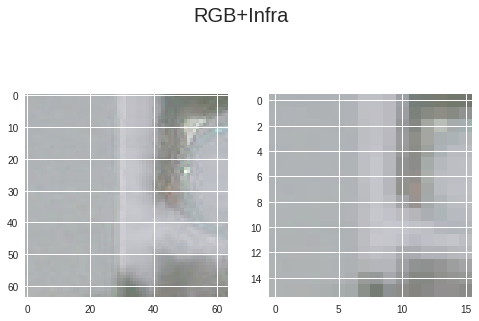

In [7]:
plt.figure().suptitle('RGB+Infra', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(im_hr[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(im_lr[0,:,:,:])

In [0]:
from tensorflow.data import Dataset
dhr = Dataset.from_tensors(im_hr)
dlr = Dataset.from_tensors(im_lr)

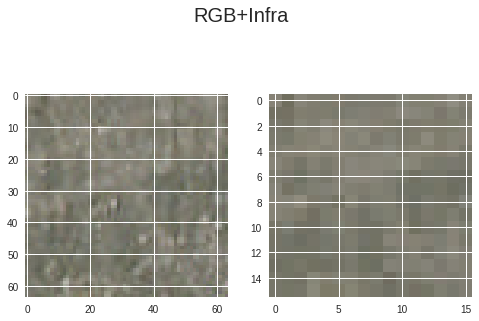

In [8]:
ix = 444
plt.figure().suptitle('RGB+Infra', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(im_hr[ix,:,:,0:3])
plt.subplot(1,2,2)
plt.imshow(im_lr[ix,:,:,0:3])

In [0]:
# Prototype the Dense SR GAN

In [0]:
#import DenseSRGAN
#gan = DenseSRGAN.DenseSRGAN(dropout_rate=0.2,hr_img_size=(64,64,3))

In [0]:
import tensorflow as tf
from tensorflow.data import Dataset
from keras.layers import Input, concatenate, Conv2D, Conv2DTranspose
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import TensorBoard

import numpy as np
import DenseBlock as db # import functions to build dense blocks

class DenseSRGAN:
    
  def __init__(self, datahr, datalr, num_gpus=1,
               hr_img_size=(64,64,4), down_factor=4,
               num_layers_in_blk = 5, num_dense_blks=2,
               growth_rate=16, num_filters=64,
               dropout_rate=0.2, weight_decay=1e-4,weights_path=None):
    
    # Batch Norm Epsillon
    self.eps = 1.1e-5
    
    self.num_gpus          = num_gpus
    
    self.datahr            = datahr
    self.datalr            = datalr
    
    hrshape = datahr.shape
    lrshape = datalr.shape
 
    self.imhr_w            = hrshape[1]
    self.imhr_h            = hrshape[2]
    self.im_c              = hrshape[3]
    self.imlr_w            = lrshape[1]
    self.imlr_h            = lrshape[2]
    self.down_factor       = int(self.imhr_w/self.imlr_w)
    
    # Square images
    assert self.imhr_w == self.imhr_h and self.imlr_w == self.imlr_h
    # Factor of 2
    assert self.down_factor%2 == 0
    # Same channels in lr and hr images
    assert hrshape[3] == lrshape[3]
 
    #self.down_factor       = down_factor
    #self.imhr_w            = hr_img_size[0]
    #self.imhr_h            = hr_img_size[1]
    #self.im_c              = hr_img_size[2]
    #self.down_factor       = down_factor
    # downsample power of 2 TODO: More Checks
    #assert down_factor%2 == 0
    #self.imlr_w            = self.imhr_w/down_factor
    #self.imlr_h            = self.imhr_h/down_factor
    
    self.num_dense_blks    = num_dense_blks
    self.blk_layers        = num_layers_in_blk
    self.growth_rate       = growth_rate
    self.num_filters       = num_filters
    self.dropout_rate      = dropout_rate
    self.weight_decay      = weight_decay
    self.weights_path      = weights_path
    self.disc              = None
    self.gen               = None
    self.disc_model        = None
    self.adv_model         = None
    
    # Initialize
    self.build_models()
    
    # TODO: Things (Not in order of importance)
    # 1. Load Data - Currently data is loaded outside then passed
    #    to the train function. Might be better to:
    #    a. Pass data to the constructor in order to get
    #       the input size before building the network
    # 2. Fix training function to do the useful things:
    #    a. Need to add additional loss functions 
    #       PSNR and maybe feature matching (ie VGG pretrain)
    #    b. like save a benchmark image on interval ie epoch
    #    c. Add a validation loss and early stopping
    # 3. Review network architecture from paper especially
    #    input/output layers ie input C3 and output FCN C1
    
  def show_size(self):
    print("W: {0} / H: {1} / C: {2}".format(self.imhr_w,self.imhr_h,self.imhr_c))
  
  def get_summary(self):
        if self.D is not None:
            self.D.summary()
        if self.gen is not None:
            self.gen.summary()

            
  '''Discriminator Archicture
      Generate the discriminator model
  '''
  
  def init_discriminator_bu(self):
    
    def d_block(layer_input, filters, strides=1, bn=True):
      """Discriminator layer"""
      d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      if bn:
          d = BatchNormalization(momentum=0.8)(d)
      return d

    d_fmaps = [64, 128, 256, 512] 
    # Input img
    hr = Input(shape=[self.imhr_w,self.imhr_h,self.im_c], name='highres_input')

    d1 = d_block(hr, 16, bn=False)
    d2 = d_block(d1, 16, strides=2)
    d3 = d_block(d2, 64)
    d4 = d_block(d3, 64, strides=2)
    d5 = d_block(d4, 128)
    d6 = d_block(d5, 128, strides=2)
    d7 = d_block(d6, 512)
    d8 = d_block(d7, 512, strides=2)

    d9 = Dense(128)(d8)
    d10 = LeakyReLU(alpha=0.2)(d9)
    out = Dense(1, activation='sigmoid')(d10)

    return Model(hr, out) 
  
  def init_discriminator(self):
    # If already defined return
    if self.disc:
      return self.disc
    
    # Defined the discriminator network
    hr_input = Input(shape=[self.imhr_w,self.imhr_h,self.im_c], name='highres_input')
    # Number of feature maps in each layer 3.4
    d_fmaps = [64, 128, 256, 512] 
    
    x = hr_input
    # Four layers with C3x3s2 
    for i,fmaps in enumerate(d_fmaps):
      base_name = 'l_{0}'.format(i)
      x = Conv2D(fmaps, (3,3),
                 padding='same', strides=(2,2),
                 name=base_name + '_conv', use_bias=False)(x)
      x = BatchNormalization(name=base_name + '_bn')(x)
      x = Activation('relu', name=base_name + '_relu')(x)
      
    # TODO: Fully Convolutional Output See Ref (same for discriminator) 3.4
    base_name = 'FC_out_' + str(i + 1)
    
    x = BatchNormalization(epsilon=self.eps, name=base_name + '_bn')(x)
    x = Activation('relu', name=base_name + '_relu')(x)
    x = Conv2D(16, (1, 1),
               name=base_name + '_conv1', use_bias=False)(x)
    # Fix the dimension TODO: try to figure out the paper
    x = Dense(d_fmaps[0])(x)
    x = Activation('relu', name=base_name + '_relu2')(x)
    x = Dense(1)(x)
    x = Activation('relu', name=base_name + '_sigmoid')(x)
    
    return Model(hr_input, x, name='discriminator')
    
    
    
  '''Generator Archicture
      Generate the generator model
  '''
  def init_generator(self):
    # Inital number of feature maps
    num_filts = self.num_filters
    
    # If already defined return
    if self.gen:
      return self.gen
       
    # Define the generator network
    lr_input = Input(shape=(self.imlr_w,self.imlr_h,self.im_c), name='lowres_input')
    
    # Initial Convolution
    x = Conv2D(num_filts, (3,3), padding='same', name='init_conv', use_bias=False)(lr_input)
    # Batch Norm / Dropout / Max Pool / etc?? Paper S3.1 "C3" What??
    x = BatchNormalization(name='init_bn')(x)
    x = Activation('relu', name='init_relu')(x)
    
    # TODO: Growth rate happens in dense block whereas in DenseNet growth 
    # occurs in transistion block. Paper 3.1 says growth in Dense Block. DONE
    
    # Dense Blocks
    for blk_idx in range(1, self.num_dense_blks + 1): # Consider 1st and last layer
      # TODO: Number of layers/block is constant blk_layers, can change per
      # block blk_layers[i] if param is list
      # num_filts += self.growth_rate
      
      x = db.dense_block(x, blk_idx, self.blk_layers, # Grow maps here TODO: Try other way
                            num_filts, self.dropout_rate,
                            self.weight_decay)
      
      num_filts += self.growth_rate
      
      x = db.trans_layer(x, blk_idx, num_filts,
                            self.dropout_rate, self.weight_decay) # Maps same here
    
    # Final Dense Block (No Growth)
    #x = db.dense_block(x, self.num_dense_blks + 1, self.blk_layers, 
    #                      num_filts, self.dropout_rate,
    #                      self.weight_decay)
    
    # Batch Norm / Dropout / Max Pool / etc?? Paper S3.1 "C3" What??
    
    base_name = 'FC_out_'
    ## OUTPUT LAYER / REPLACE DENSE BLOCK ABOVE paper s 3.1    
    # TODO: Fully Convolutional Output See Ref (same for discriminator)    
    x = Conv2D(num_filts, (3,3), padding='same', name=base_name + '_c3x3s1', use_bias=False)(x)
    x = BatchNormalization(name=base_name + '_bn_1')(x)
    x = Activation('relu', name=base_name + '_relu_1')(x)
    x = Conv2D(num_filts, (1,1), padding='same', name=base_name + '_c1x1s1', use_bias=False)(x)
    x = BatchNormalization(name=base_name + '_bn_2')(x)
    x = Activation('relu', name=base_name + '_relu_2')(x)

    #x = BatchNormalization(epsilon=self.eps, name=base_name + '_bn')(x)
    #x = Activation('relu', name=base_name + '_relu')(x)
    x = Conv2D(self.im_c, (1, 1), name=base_name + '_conv1', use_bias=False)(x)
    x = Activation('sigmoid', name=base_name + '_sigmoid')(x)

    return Model(lr_input, x, name='generator')

    
    
  def build_models(self):
    
    lr    = 4e-4
    clip  = 1.0
    decay = 1e-8
    
    # Initialize architectures
    self.disc  = self.init_discriminator()
    self.gen = self.init_generator()
    
    if self.weights_path is not None:
      self.gen.load_weights(self.weights_path +
                            'generator_weights.h5')
      self.disc.load_weights(self.weights_path +
                             'discriminator_weights.h5')
    
    # Create the model 
    if self.num_gpus > 1:
      self.disc_model = multi_gpu_model(self.disc, gpus=self.num_gpus)
    else:
      self.disc_model = self.disc
      
      
    
    
    
    # Compile Discriminator Model
    doptimizer = RMSprop(lr=lr, decay=decay, clipvalue=clip)
    self.disc_model.compile(loss='mse',
                      optimizer=doptimizer,
                      metrics=['accuracy'])    
   
    #self.disc_model = Sequential()
    #self.disc_model.add(self.disc)
    #self.disc_model.compile(loss='binary_crossentropy',
    #                         optimizer = doptimizer,
    #                         metrics=['accuracy'])

    # Compile Adversarial Model
    goptimizer = RMSprop(lr=lr/2, decay=decay, clipvalue=clip)
    self.disc.trainable = False
    im_lr = Input(shape=(self.imlr_w,self.imlr_h,self.im_c))
    im_hr = Input(shape=(self.imhr_w,self.imhr_h,self.im_c))
    
    # Generated HR Images
    gen_hr = self.gen(im_lr)
    
    # Discriminator on Generator Output
    disc_gen_hr = self.disc(gen_hr)
    
    self.adv_model = Model(im_lr, disc_gen_hr)

    # Create the model 
    if self.num_gpus > 1:
      self.adv_model = multi_gpu_model(Model(im_lr, disc_gen_hr), gpus=self.num_gpus)
    else:
      self.adv_model = Model(im_lr, disc_gen_hr)    
    
    
    self.adv_model.compile(loss=['binary_crossentropy'],
                           #loss_weights=[1e-3,1],
                           optimizer=goptimizer,
                           metrics=['accuracy'])
    
    #self.adv_model = Sequential()
    #self.adv_model.add(self.gen)
    #self.adv_model.add(self.gen)
    #self.adv_model.compile(loss='binary_crossentropy',
    #                optimizer=goptimizer,
    #                metrics=['accuracy'])
    
    
  ''' TRAIN '''
  def train(self, datahr=None, datalr=None,
            epochs=1, batch_size=16, callbacks=None,
            save_interval=1):
     
    #datahr = self.datahr if datahr is None else datahr
    #datalr = self.datalr if datalr is None else datalr
    
            
    running_loss = []
    
    # TODO: This just throws away the remaining expamples if not batch_size not divisor of num_train
    num_train   = len(self.datahr)
    num_batches = num_train/batch_size if num_train%batch_size == 0 else num_train/batch_size - 1
    num_batches = int(num_batches)
    
    # if save_interval > 0: grab and hold a random lr input for benchmarking
    if save_interval > 0:
        bench_idx = np.random.randint(1,num_train - 1,1)
        bench_lr  = self.datalr[bench_idx,:,:,:]
        bench_hr  = self.datahr[bench_idx,:,:,:]
        
    for epoch in range(epochs):
        
        # Shuffle the indices TODO: Shuffle batch in place
        idx = np.random.permutation(list(range(num_train - 1)))
        
        # Gives error 
        # ValueError: If your data is in the form of symbolic tensors,
        # you should specify the `steps` argument 
        #(instead of the `batch_size` argument, 
        #because symbolic tensors are expected to
        #produce batches of input data).
        #
        #datahr = tf.gather(self.datahr,idx)
        #datalr = tf.gather(self.datalr,idx)
        #self.datalr = tf.random.shuffle(self.datalr)
        #self.datahr = tf.random.shuffle(self.datahr)
        
        # Grab batch_size images from training data both lr and hr
        for batch_idx in range(int(num_batches/2)): # Take 2 batches per round
            bix_begin = batch_idx*batch_size
            bix_end   = bix_begin+batch_size

            # generate fake hr images with generator.predict(lr_imgs) size of batch
            #batch_lr = datalr[bix_begin:bix_end,:,:,:]
            #batch_hr = datahr[bix_begin:bix_end,:,:,:]
            batch_lr = np.array([self.datalr[i,:,:,:] for i in idx[bix_begin:bix_end]])
            batch_hr = np.array([self.datahr[i,:,:,:] for i in idx[bix_begin:bix_end]])        
            
            
            x_gen = self.gen.predict(batch_lr)
            x_tr  = batch_hr
            #x_tr  = np.concatenate((batch_hr,x_gen))
            y_tr  = np.ones((len(x_tr),) + (4,4,1))
            y_gen = np.zeros((len(x_gen),) + (4,4,1)) 
            
            #print('D Train Size: {0}'.format(x_tr.shape))
            # Train the discriminator alone
            d_loss_hr  = self.disc_model.train_on_batch(x_tr, y_tr)
            d_loss_gen = self.disc_model.train_on_batch(x_gen, y_gen)
            
            # Grab another batch_size of images just for end to end training for adversarial model self.adv_model
            bix_begin = bix_end
            bix_end   = bix_begin + batch_size
            #batch_lr = datalr[bix_begin:bix_end,:,:,:]
            batch_lr = np.array([self.datalr[i,:,:,:] for i in idx[bix_begin:bix_end]])    
            
            y_tr = np.ones((batch_size,)+(4,4,1))
            x_tr = batch_lr
            
            #print('GAN Train Size: {0}'.format(x_tr.shape))
            a_loss = self.adv_model.train_on_batch(x_tr, y_tr)
            log_mesg = "%d: [D loss_hr: %f, acc_hr: %f, loss_gen: %f, acc_gen: %f]" % \
                            (batch_idx, d_loss_hr[0], d_loss_hr[1], d_loss_gen[0], d_loss_gen[1])
            
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            
            # Print loss, call callbacks, save benchmarks if interval, etc...
            #print(log_mesg)
            running_loss.append([epoch] + [batch_idx] + list(d_loss_hr) + list(d_loss_gen) + list(a_loss))
            np.save(dir_pfx + 'loss_log.npy', arr=np.array(running_loss))
            
            #if batch_idx % save_interval:
               
            
        print(log_mesg)
        #self.gen.save("generator_weights.h5")

        # If save, save a pic
        if save_interval > 0:
            #print(bench_hr.shape)
            #print(bench_lr.shape)
            img = gan.gen.predict(bench_lr).squeeze()
            img = (img + 1)/2
            plt.figure().suptitle('HR + Prediction: Epoch {0}'.format(epoch), fontsize=20)
            plt.subplot(1,2,1)
            plt.imshow(bench_hr.squeeze())
            plt.subplot(1,2,2)
            plt.imshow(img)
            plt.savefig('{0}images/bench_epoch_{1}'.format(dir_pfx,epoch))

        np.save(dir_pfx + 'loss_log_epoch.npy', arr=np.array(running_loss))  
        
        if epoch%10 == 0:
            print('Epoch: {0}'.format(epoch))
            self.gen.save(dir_pfx + 'weights/generator_weights.h5')
            self.disc.save(dir_pfx + 'weights/discriminator_weights.h5')


In [0]:
# Try RGB Channels
gan = DenseSRGAN(im_hr,im_lr,num_gpus=1,dropout_rate=0.3,weights_path=dir_pfx + 'weights/')
# Save weights
#gan = DenseSRGAN(dropout_rate=0.3,weights_path='./generator_weights.h5')

In [0]:
'''/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
'''
#gan.dropout_rate = .5
gan.train(epochs=20)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


151: [D loss_hr: 0.001608, acc_hr: 1.000000, loss_gen: 0.004836, acc_gen: 0.996094]  [A loss: 12.649376, acc: 0.019531]
Epoch: 0
151: [D loss_hr: 0.000130, acc_hr: 1.000000, loss_gen: 0.000000, acc_gen: 1.000000]  [A loss: 0.013667, acc: 1.000000]
151: [D loss_hr: 0.000088, acc_hr: 1.000000, loss_gen: 0.000000, acc_gen: 1.000000]  [A loss: 0.013693, acc: 1.000000]
151: [D loss_hr: 0.000361, acc_hr: 1.000000, loss_gen: 0.000000, acc_gen: 1.000000]  [A loss: 0.005670, acc: 1.000000]


In [0]:
gan.disc.save(dir_pfx + 'weights/discriminator_weights.h5')

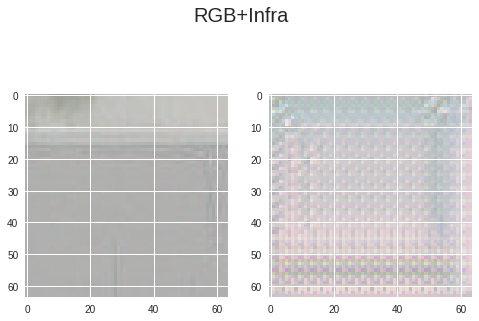

In [19]:
ix = 40

img = gan.gen.predict(im_lr[ix:ix+1,:,:,:]).squeeze()
img = (img + 1)/2
plt.figure().suptitle('RGB+Infra', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(im_hr[ix,:,:,:])
plt.subplot(1,2,2)
plt.imshow(img)

Mean Loss Real Images: 0.5794886350631714
Mean Loss False Images: 0.5696948170661926


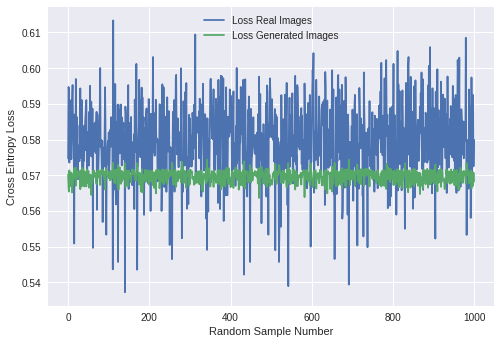

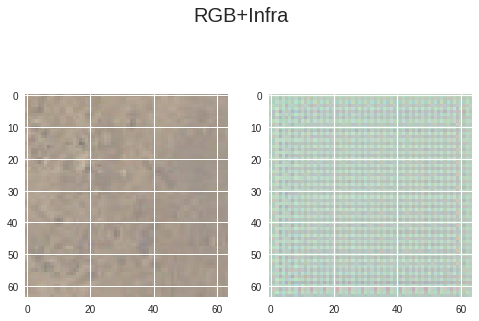

In [73]:
floss = []
tloss = []

for i in np.random.randint(low=0,high=len(im_lr),size=(1000)):
  tloss.append(gan.disc.predict(im_hr[i:i+1,:,:,:]).squeeze())
  floss.append(gan.disc.predict(gan.gen.predict(im_lr[i:i+1,:,:,:])).squeeze())

  
print('Mean Loss Real Images: {0}'.format(np.mean(tloss)))
print('Mean Loss False Images: {0}'.format(np.mean(floss)))


plt.figure()
plt.plot(list(range(len(tloss))),tloss)
plt.plot(list(range(len(floss))),floss)
plt.legend(['Loss Real Images','Loss Generated Images'])
plt.xlabel('Random Sample Number')
plt.ylabel('Cross Entropy Loss')
plt.show